In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
cmap = 'bwr'

from PIL import Image

# for step 0
import os
import re

# for step 1
from collections import defaultdict

# for step 2
from scipy.signal import savgol_filter

In [2]:
class ScatteringData:
    def __init__(self, Q, I, I_err, dQ):
        index = Q>0
        self.Q = Q[index]
        self.I = I[index]
        self.I_err = I_err[index]
        self.dQ = dQ[index]

In [4]:
# manual rebinning
def rebin_data(scattering_data, rebin_factor):
    """
    Manually rebin scattering data by a given integer factor.
    Propagates uncertainty correctly.
    """
    if not isinstance(rebin_factor, int) or rebin_factor <= 1:
        raise ValueError("Rebin factor must be an integer greater than 1.")
    
    Q_orig = scattering_data.Q
    I_orig = scattering_data.I
    I_err_orig = scattering_data.I_err
    dQ_orig = scattering_data.dQ

    # Pad data if necessary to make it divisible by the rebin factor
    padding = rebin_factor - (len(Q_orig) % rebin_factor)
    if padding != rebin_factor:
        Q_padded = np.pad(Q_orig, (0, padding), 'edge')
        I_padded = np.pad(I_orig, (0, padding), 'edge')
        I_err_padded = np.pad(I_err_orig, (0, padding), 'edge')
    else:
        Q_padded = Q_orig
        I_padded = I_orig
        I_err_padded = I_err_orig

    num_new_bins = len(Q_padded) // rebin_factor
    
    # Reshape and rebin
    Q_new = np.mean(Q_padded.reshape(-1, rebin_factor), axis=1)
    I_new = np.mean(I_padded.reshape(-1, rebin_factor), axis=1)
    
    # Propagate uncertainty (sum in quadrature, then average)
    I_err_new = np.sqrt(np.sum(I_err_padded.reshape(-1, rebin_factor)**2, axis=1)) / rebin_factor
    
    # Calculate new bin width: interpolate dQ to Q_new and multiply by rebin factor
    dQ_interp = interp1d(Q_orig, dQ_orig, kind='linear', bounds_error=False, fill_value='extrapolate')
    dQ_new = dQ_interp(Q_new) * rebin_factor
    
    return ScatteringData(Q_new, I_new, I_err_new, np.full_like(Q_new, dQ_new))

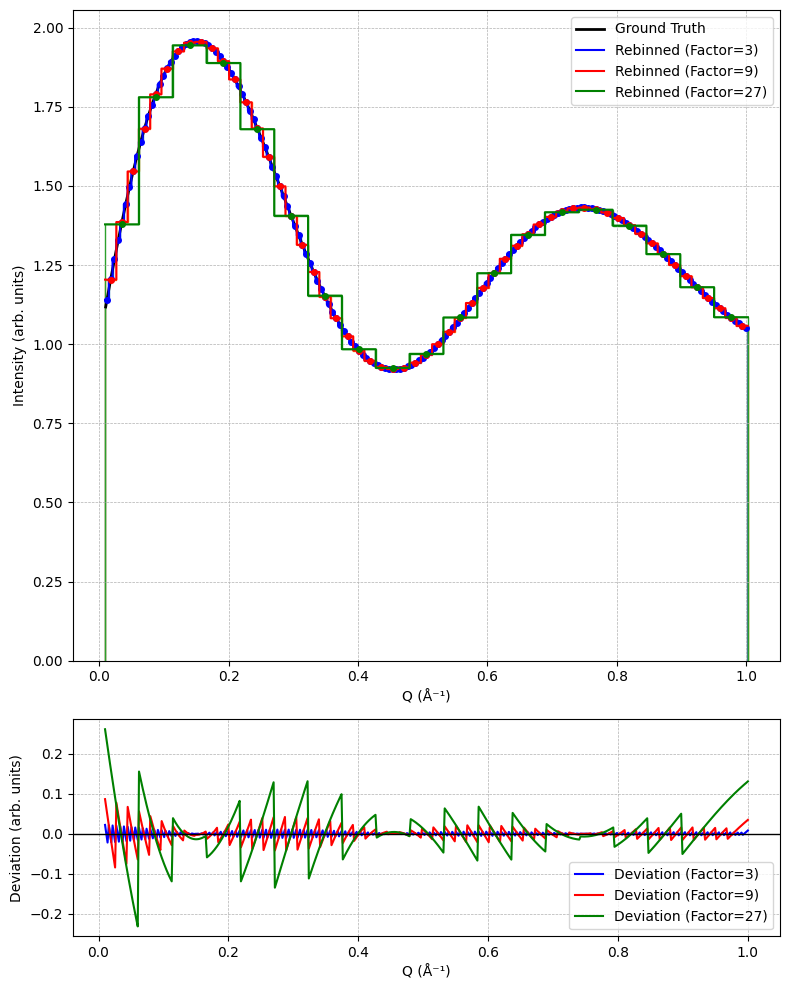

In [ ]:

# -------------------------------------------------------------------------
# Step 1: Create synthetic data
# -------------------------------------------------------------------------
# Create a smooth, high-resolution "ground truth" I(Q) curve with some features
Q_ground_truth = np.linspace(0.01, 1, 512)
I_ground_truth = (np.sin(2 * Q_ground_truth) + np.sin(10 * Q_ground_truth)) * np.exp(-2 * Q_ground_truth) + 1
I_err_ground_truth = np.sqrt(I_ground_truth) * 0.1 # Example counting error
dQ_ground_truth = np.full_like(Q_ground_truth, np.mean(np.diff(Q_ground_truth)))

best_data = ScatteringData(Q_ground_truth, I_ground_truth, I_err_ground_truth, dQ_ground_truth)

# -------------------------------------------------------------------------
# Step 2: Rebin the data with different factors
# -------------------------------------------------------------------------
def create_step_data(Q_data, I_data):
    dQ = np.mean(np.diff(Q_data))
    Q_step_points = np.empty(len(Q_data) * 2)
    I_step_points = np.empty(len(I_data) * 2)
    
    Q_step_points[0::2] = Q_data - dQ/2
    Q_step_points[1::2] = Q_data + dQ/2
    
    I_step_points[0::2] = I_data
    I_step_points[1::2] = I_data
    
    return Q_step_points, I_step_points

def centers_to_edges(Q_centers, dQ):
    # Q_centers: array of bin centers
    # dQ can be scalar or array per-bin width
    dQ_arr = np.asarray(dQ)
    if dQ_arr.ndim == 0:
        dQ_arr = np.full_like(Q_centers, float(dQ_arr))
    left = Q_centers - dQ_arr / 2.0
    right_last = Q_centers[-1] + dQ_arr[-1] / 2.0
    # edges has length = len(Q_centers) + 1
    edges = np.r_[left, right_last]
    return edges

rebin_factors = [3, 9, 27]
rebinned_data_list = []
step_data_list = []
hist_data_list = []

for rebin_factor in rebin_factors:
    rebinned_data = rebin_data(best_data, rebin_factor)
    rebinned_data_list.append((rebin_factor, rebinned_data))
    
    # for histogram-style plotting
    edges = centers_to_edges(rebinned_data.Q, rebinned_data.dQ)
    hist_data_list.append((rebin_factor, edges, rebinned_data.I))
    
    Q_step, I_step = create_step_data(rebinned_data.Q, rebinned_data.I)
    step_data_list.append((rebin_factor, Q_step, I_step))

# -------------------------------------------------------------------------
# Step 3: Plot the results
# -------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [3, 1]})

# Top subplot: Ground truth vs. Binned data as a step function
ax1.plot(best_data.Q, best_data.I, color='k', linewidth=2, label='Ground Truth')

colors = ['b', 'r', 'g', 'm', 'c']

# # Histogram-style rebinned curves
# for idx, (rebin_factor, edges, heights) in enumerate(hist_data_list):
#     color = colors[idx % len(colors)]
#     try:
#         # Preferred: proper histogram stairs with filled rectangles
#         ax1.stairs(heights, edges, fill=True, alpha=0.3, color=color)
#         # Draw a thin outline for readability
#         ax1.stairs(heights, edges, fill=False, linewidth=1)
#     except Exception:
#         # Fallback if stairs(fill=...) not available: use bar()
#         bin_centers = 0.5 * (edges[:-1] + edges[-1:])  # not used; just to show idea
#         widths = np.diff(edges)
#         ax1.bar(0.5*(edges[:-1]+edges[1:]), heights, width=widths, align='center', alpha=0.3,
#                 label=f'Rebinned (Factor={rebin_factor})', edgecolor='black', linewidth=0.8)

for idx, (rebin_factor, Q_step, I_step) in enumerate(step_data_list):
    color = colors[idx % len(colors)]
    ax1.plot(Q_step, I_step, color=color, linestyle='-', label=f'Rebinned (Factor={rebin_factor})')
    ax1.plot(rebinned_data_list[idx][1].Q, rebinned_data_list[idx][1].I, 'o', color=color, markersize=4)

ax1.set_xlabel('Q (Å⁻¹)')
ax1.set_ylabel('Intensity (arb. units)')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Bottom subplot: Deviation from ground truth
for idx, (rebin_factor, Q_step, I_step) in enumerate(step_data_list):
    color = colors[idx % len(colors)]
    f_rebin = interp1d(Q_step, I_step, kind='previous', bounds_error=False, fill_value="extrapolate")
    deviation = f_rebin(best_data.Q) - best_data.I
    ax2.plot(best_data.Q, deviation, color=color, linestyle='-', label=f'Deviation (Factor={rebin_factor})')

ax2.axhline(0, color='k', linewidth=1, linestyle='-')
ax2.set_xlabel('Q (Å⁻¹)')
ax2.set_ylabel('Deviation (arb. units)')
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
